# Main Analysis Pipeline

In [1]:
import sys
sys.path.insert(0, '../modules')
from hits import CDCHits, CTHHits, CDCHits, FlatHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter
from root_numpy import list_branches
%load_ext memory_profiler
from tracking import HoughSpace
from scipy import sparse
from tracking import HoughTransformer, HoughShifter
from cylinder import CDC

# Convenience Functions

In [2]:
# The most common are stored in these notebooks
%run visualizations.ipynb
%run data_tools.ipynb

Populating the interactive namespace from numpy and matplotlib


In [3]:
def set_additional_branches(sample, row_name=None, cell_id=None, relative_time=None):
    """
    Set the trigger time and cell ID branches
    """
    if row_name:
        sample.data[row_name] = sample.geom.get_layers(sample.data[sample.flat_name])
    if cell_id:
        sample.data[cell_id] = sample.geom.get_indexes(sample.data[sample.flat_name])
    if relative_time:
        sample.data[relative_time] = sample.data[sample.time_name] - sample.data[sample.trig_name]

## Access data

In [4]:
def get_measurment_and_neighbours(hit_sample, measurement, events=None):
    """
    Get the measurement on the wire and its neighbours in a classification-friendly way
    
    :return: a list of three numpy arrays of measurement 1) on wire, 2) to left, 3) to right
    """
    return [hit_sample.get_measurement(measurement, 
                                       events, 
                                       shift=i, 
                                       only_hits=True, 
                                       flatten=True) 
                for i in [0,-1,1]] 

## Import the Signal Hits

In [5]:
def test_labelling(hit_sample, sig_name, momentum_name, value):
    current_labels = hit_sample.get_events()[sig_name]
    momentum_magnitude = np.sqrt(np.square(hit_sample.get_events()[momentum_name+'.fX']) +\
                                 np.square(hit_sample.get_events()[momentum_name+'.fY']) +\
                                 np.square(hit_sample.get_events()[momentum_name+'.fZ']))
    pid_values = hit_sample.get_events()[pid_name]
    new_labels = np.logical_and(momentum_magnitude > value, pid_values == 11)
    print "Number of signal now : {}".format(sum(current_labels))
    print "Number of signal actual : {}".format(sum(new_labels))
    print "Number mislabelled : {}".format(hit_sample.n_hits - sum(current_labels == new_labels))

### Make cuts

In [6]:
def remove_coincidence_old(hit_samp):
    print "Hits before coincidence removal : {}".format(hit_samp.n_hits)
    # Sort events by channel, by score
    hit_samp.sort_hits([hit_samp.flat_name, lcl_scr_name])
    # Recored which hit have the best score by event by channel
    all_hits_to_take = []
    # Stats about hit removal
    removal_stats = {"is_sig, more_sig"    : 0,
                     "is_sig, no_more_sig" : 0,
                     "not_sig, more_sig"    : 0,
                     "not_sig, no_sig"      : 0}

    # Loop over all events
    for evt in range(hit_samp.n_events):
        event_hits = hit_samp.get_events(evt)
        for channel in np.unique(event_hits[hit_samp.flat_name]):
            chan_hits = hit_samp.filter_hits(hit_samp.flat_name, these_hits=event_hits, values=channel)
            this_chan_hit = chan_hits[hit_samp.hits_index_name][-1]
            all_hits_to_take.append(this_chan_hit)
            # Check for coincidence
            if len(chan_hits) > 1:
                # Check the channel content
                is_sig = hit_samp.data[this_chan_hit][hit_samp.hit_type_name] == 1
                # Check if there was more signal
                has_more_sig = (sum(chan_hits[hit_samp.hit_type_name] == 1) - is_sig) > 0
                # Check which hit we chose
                if is_sig and has_more_sig:
                    removal_stats["is_sig, more_sig"] += 1
                elif is_sig and not has_more_sig:
                    removal_stats["is_sig, no_more_sig"] += 1
                elif not is_sig and has_more_sig:
                    removal_stats["not_sig, more_sig"] += 1
                else:
                    removal_stats["not_sig, no_sig"] += 1
    pprint(removal_stats)
    print sum(hit_samp.get_events()["CDCHit.fIsSig"])
    print sum(removal_stats.values())

    # Make a mask
    chan_hit_mask = np.zeros(hit_samp.n_hits, dtype=bool)
    chan_hit_mask[all_hits_to_take] = 1
    # Set the hits to take as channel hit
    hit_samp.data[take_hit_name][chan_hit_mask] = 1
    # Trim the hits we are not going to look at
    hit_samp.trim_hits(take_hit_name, values=1)
    hit_samp.sort_hits(hit_samp.flat_name)
    print "Hits after coincidence removal : {}".format(hit_samp.n_hits)

In [7]:
def remove_coincidence(hit_samp, remove_hits=True):
    # Sort by local score name
    hit_samp.sort_hits(lcl_scr_name, ascending=False)
    all_hits_keep = hit_samp.get_measurement(hit_samp.hits_index_name, only_hits=True)
    # Make a mask   
    hit_samp.data[take_hit_name][all_hits_keep.astype(int)] = 1
    # Remove the hits
    if remove_hits:
        hit_samp.trim_hits(take_hit_name, values=1)
        hit_samp.sort_hits(hit_samp.flat_name)
        #preferred_hits = hit_samp.get_measurement(hit_samp.hits_index_name, 
        #                                          only_hits=True, 
        #                                          flatten=True).astype(int)
        #hit_samp.data = hit_samp.data[preferred_hits]
        #hit_samp._reset_event_to_n_hits()

## Define Our Samples

In [8]:
## Branches not needed
#drift_dist_name = prefix + "DriftDist"
#turn_id_name = prefix + "TurnID"
#pid_name = prefix + "Track.fPID"
#parent_track_id_name = prefix + "Track.fParentTrackID"
#all_momentum_names = [ prefix + "Track.f" + st_sp + "Momentum.f" + coor 
#                       for st_sp in ["Start", "Stop"] for coor in ["X", "Y", "Z"] ]
#all_pos_names = [ prefix + "Track.f" + st_sp + "PosGlobal.f" + coor 
#                       for st_sp in ["Start", "Stop"] for coor in ["P.fX", "P.fY", "P.fZ", "E"] ]
#hit_pos_names = [ prefix + "MCPos.f" + coor for coor in ["P.fX", "P.fY", "P.fZ", "E"] ]
#hit_mom_names = [ prefix + "MCMom.f" + coor for coor in ["X", "Y", "Z"] ]

## For track fitting
#these_branches += [turn_id_name, 
#                   drift_dist_name,
#                   pid_name,
#                   parent_track_id_name] +\
#                  hit_mom_names +\
#                  all_momentum_names +\
#                  all_pos_names +\
#                  hit_pos_names

In [9]:
# Define some branches to import
## Existing branches
prefix = "CDCHit.f"
drift_name = prefix + "DriftTime"
track_id_name = prefix + "Track.fTrackID"


## Branches to be filled
row_name = prefix +"Layers"
cell_id_name = prefix + "CellID"
rel_time_name = prefix + "Relative_Time"
take_hit_name = prefix + "Take_Hit"
lcl_scr_name = prefix + "Local_Score"
ngh_scr_name = prefix + "Neigh_Score"
hgh_scr_name = prefix + "Hough_Score"
trk_scr_name = prefix + "Track_Score"

empty_branches = [row_name, 
                  cell_id_name,
                  lcl_scr_name, 
                  ngh_scr_name, 
                  hgh_scr_name,
                  trk_scr_name, 
                  rel_time_name,
                  take_hit_name]

In [10]:
these_branches = dict()
these_branches["CDC"] = [drift_name, 
                         track_id_name]
these_branches["CTH"] = None

In [11]:
file_root = "/home/elg112/development/ICEDUST/track_finding_standalone/"\
            "track_finding_yandex/data/"
back_samples = ["batch_2_TrkTree_2500.root",
                "batch_3_TrkTree_2536.root",
                "batch_4_TrkTree_5250.root"]
sig_samples = ["oa_xx_xxx_09000000-0000_pdevedxn64ot_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09100000-0000_skzt2l7sdqvx_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09200000-0000_x67rltrbhc3n_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09300000-0000_seae7w5z6fvt_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09400000-0000_o774i4trtmim_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09500000-0000_ufkycd74hb4i_user-TrkTree_000_500signal-label.root"]
back_samples = [file_root + this_file for this_file in back_samples]
sig_samples = [file_root + this_file for this_file in sig_samples]

## Import the Data

In [12]:
%run data_tools.ipynb

In [13]:
%%memit
train = data_import_sample(sig_samples[0], back_samples[0], 
                           these_cuts=["500","Trig","Track"],
                           branches=these_branches,
                           empty_branches=empty_branches)
set_additional_branches(train.cdc, 
                        row_name=row_name, 
                        cell_id=cell_id_name, 
                        relative_time=rel_time_name)

Using cuts
{ 'CDC': 'CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500 && 1 == 1 && 1 == 1',
  'CTH': 'CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500 && 1 == 1 && 1 == 1'}
Getting branches
{'CDC': ['CDCHit.fDriftTime', 'CDCHit.fTrack.fTrackID'], 'CTH': None}
Using cuts
{ 'CDC': 'CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500 && CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1',
  'CTH': 'CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500 && CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1'}
Getting branches
{'CDC': ['CDCHit.fDriftTime', 'CDCHit.fTrack.fTrackID'], 'CTH': None}
Trimming Signal Events
CTH Sig Events 2493 
CTH Back Events 2493 
CDC Sig Events 2493 
CDC Back Events 2493 
peak memory: 1028.34 MiB, increment: 913.47 MiB


## Prepare the data

In [14]:
bins_for_plots = 50
figsize(10,5)

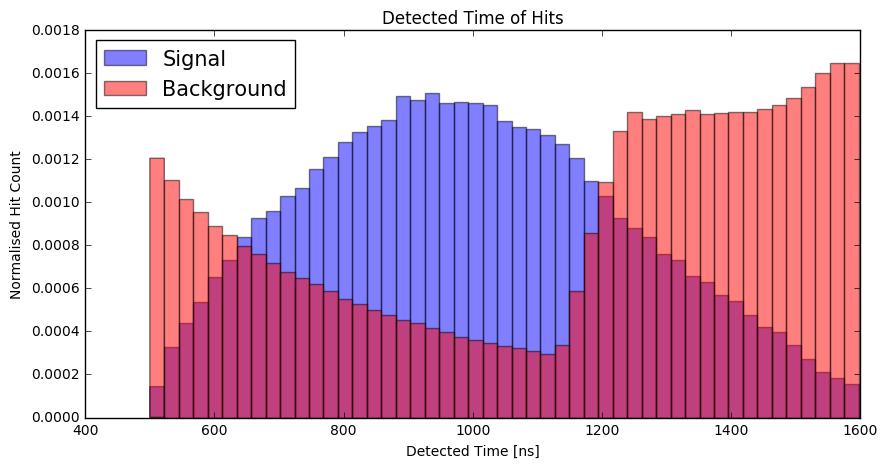

In [15]:
plot_feature( train.cdc.get_signal_hits()[train.cdc.time_name], 
              train.cdc.get_background_hits()[train.cdc.time_name], 
              xlabel="Detected Time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Detected Time of Hits", 
              nbins=bins_for_plots)
show()

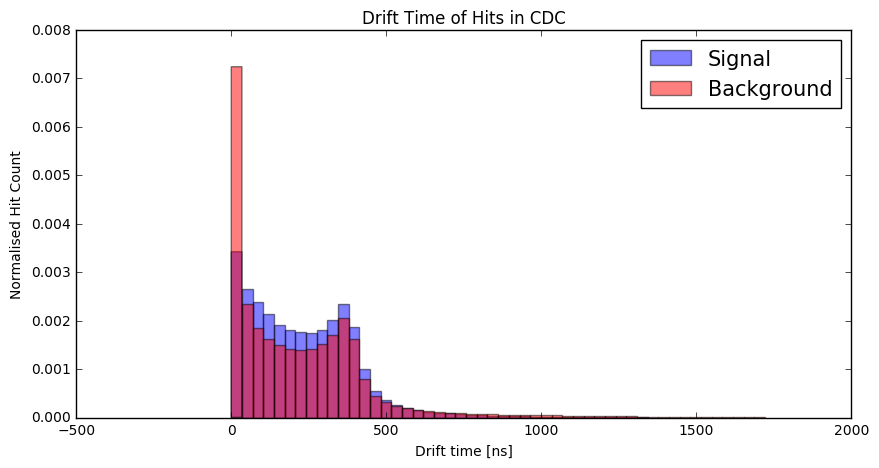

In [16]:
plot_feature( train.cdc.get_signal_hits()[drift_name], 
              train.cdc.get_background_hits()[drift_name], 
              xlabel="Drift time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Drift Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

In [17]:
event = 1000
print np.unique(train.cth.get_events(event)["CTHHit.fTrigTime"])
print np.unique(train.cth.get_events(event)["CTHHit.fEventNumber"])
print np.unique(train.cdc.get_events(event)["CDCHit.fTrigTime"])
print np.unique(train.cdc.get_events(event)["CDCHit.fEventNumber"])

[    0.         1093.7331543]
[   4366 9046437]
[ 1093.7331543]
[   4366 9046437]


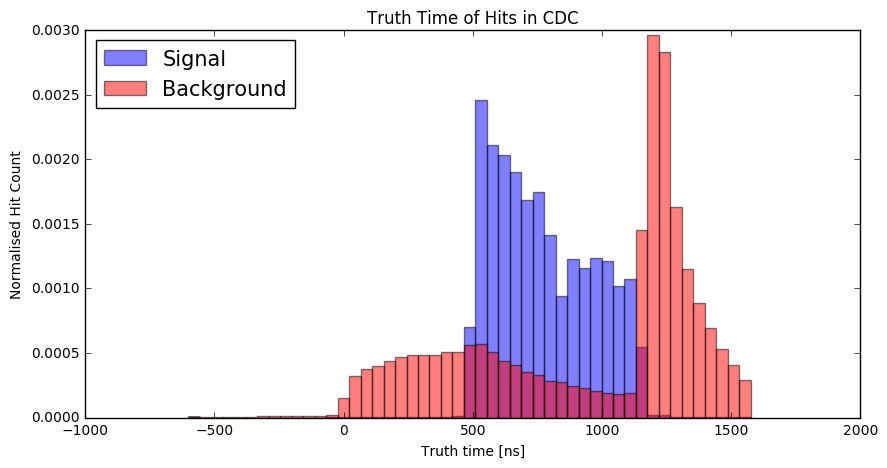

In [18]:
plot_feature( train.cdc.get_signal_hits()[train.cdc.time_name] -\
                  train.cdc.get_signal_hits()[drift_name],  
              train.cdc.get_background_hits()[train.cdc.time_name] -\
              train.cdc.get_background_hits()[drift_name], 
              xlabel="Truth time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Truth Time of Hits in CDC",  
              nbins=bins_for_plots)
show()

# Begin the Analysis

In [26]:
bins_for_plots = 50
figsize(10,5)

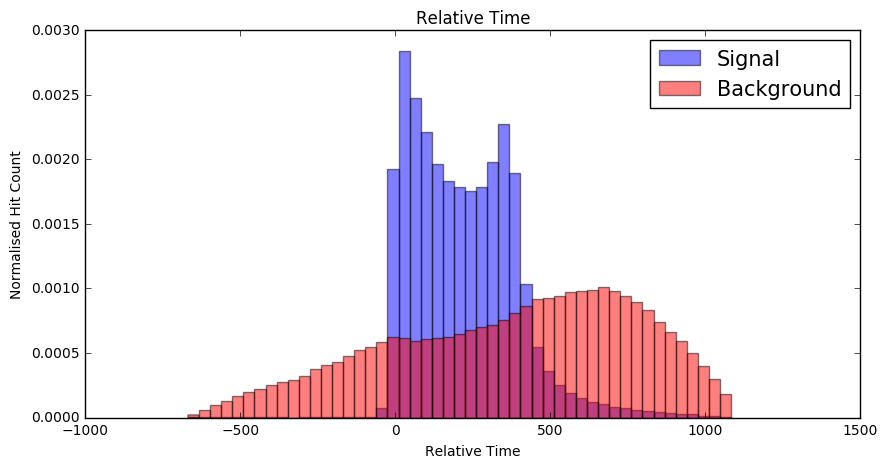

In [27]:
plot_feature( train.cdc.get_signal_hits()[rel_time_name],
              train.cdc.get_background_hits()[rel_time_name],
              xlabel="Relative Time", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Relative Time", 
              nbins=bins_for_plots)
show()

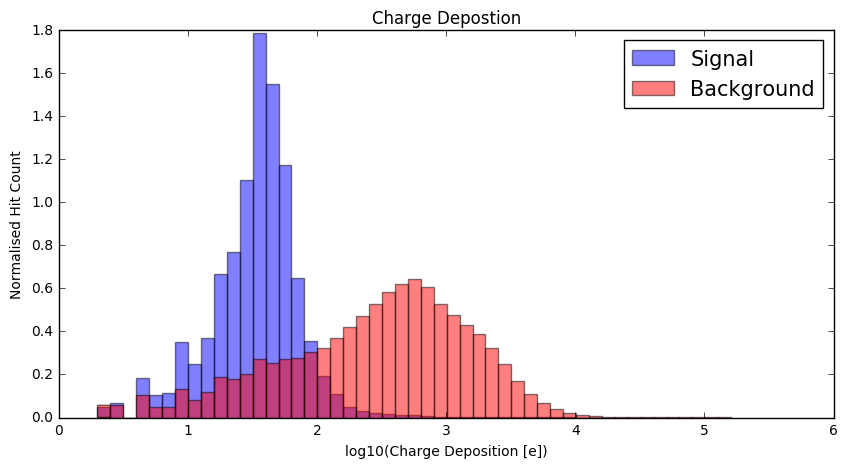

In [70]:
plot_feature( np.log10(train.cdc.get_signal_hits()[train.cdc.edep_name] + 1), 
              np.log10(train.cdc.get_background_hits()[train.cdc.edep_name] + 1), 
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=bins_for_plots)
show()

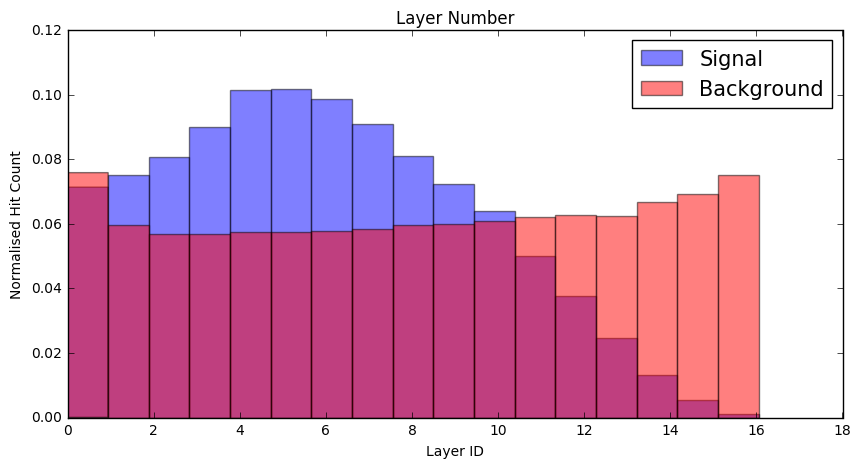

In [71]:
plot_feature( train.cdc.get_signal_hits()[row_name], 
              train.cdc.get_background_hits()[row_name], 
              xlabel="Layer ID", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Layer Number", 
              nbins=18)
show()

In [72]:
print train.cdc.geom.n_points

4482


In [73]:
sig_occ, back_occ, occ = train.cdc.get_occupancy()

Sig Occ: 80.6385880465 , Back Occ : 603.115523466
All Occ: 672.533894906, 0.150052185387
NumHits: 794.496991576
MinMultiHit: 0.181348624351


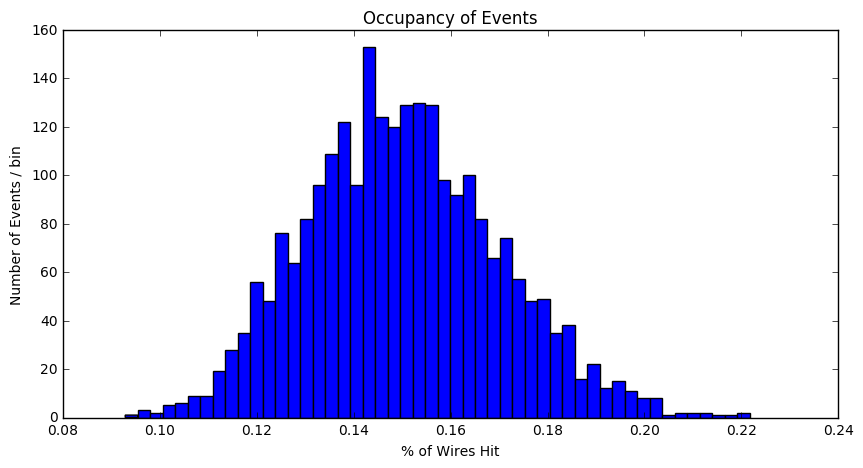

In [74]:
plt.title("Occupancy of Events")
plt.xlabel("% of Wires Hit")
plt.ylabel("Number of Events / bin")
plt.hist(np.array(occ)/4482., bins=50)
plt.show()

In [75]:
%run visualizations.ipynb
figsize(10,5)

Populating the interactive namespace from numpy and matplotlib


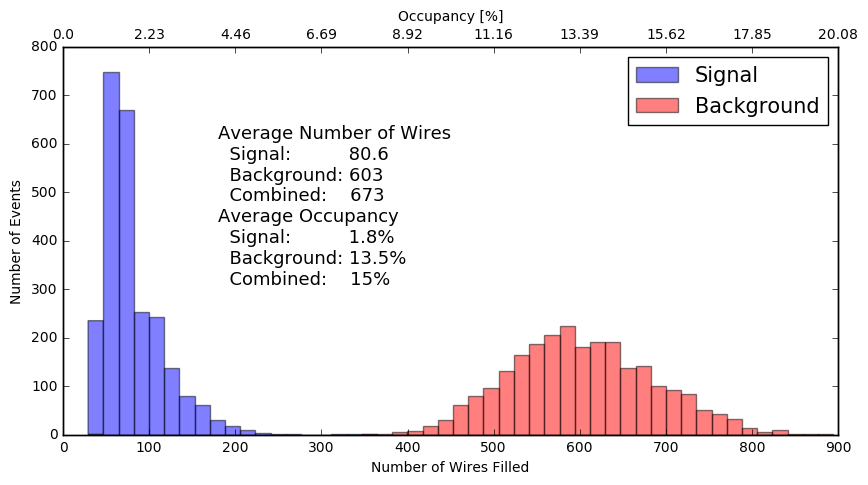

In [76]:
plot_occupancies(sig_occ, back_occ, occ,
                n_vols=4482, x_pos=0.2, y_pos=0.8)

## Local Classification : Deal with Coincidence

### Make training/testing splits

In [77]:
def reset_masks(evt_samp, hit_sample):
    total_events = hit_sample.n_events
    total_hits = hit_sample.n_hits

    evt_samp_masks = [ np.zeros(total_events, dtype=bool) for samp in evt_samp ]
    hit_masks      = [ np.zeros(total_hits, dtype=bool) for samp in evt_samp ]
    for i in range(len(evt_samp)):
        evt_samp_masks[i][evt_samp[i]] = True
        hit_masks[i][hit_sample.get_events(evt_samp[i])[hit_sample.hits_index_name]] = True
    return evt_samp_masks, hit_masks

In [78]:
# Split up the data first
from sklearn.cross_validation import train_test_split

# Seed for sample mixing
seed = 10

# Get samples
rest = range(train.cdc.n_events)
rest, sample_3     = train_test_split(rest, train_size=0.54, test_size=0.36, random_state=seed)
sample_1, sample_2 = train_test_split(rest, train_size=0.33, test_size=0.66, random_state=seed)

# Get event masks
evt_samp       = [ sample_1, sample_2, sample_3 ]
evt_samp_masks, hit_masks = reset_masks(evt_samp, train.cdc)

In [79]:
# Get a measurement to compare
#orig_edep = np.sort(train.cdc.get_events(evt_samp[0])[train.cdc.edep_name])
#new_edep = np.sort(train.cdc.get_events(new_samples[0])[train.cdc.edep_name])

In [80]:
# Remove unused events
all_events = evt_samp[0] + evt_samp[1] + evt_samp[2]
evt_name = []
for samp in evt_samp:
    evt_name.append(np.unique(train.cdc.get_events(samp)[train.cdc.key_name]))
good_events = np.unique(train.cdc.get_events(all_events)[train.cdc.key_name])
train.cdc.trim_hits(train.cdc.key_name, values=good_events)
# Relabel the hit samples
evt_samp = []
for new_samp in evt_name:
    this_hit = train.cdc.filter_hits(train.cdc.key_name, values=new_samp)[train.cdc.hits_index_name]
    this_evt = list(np.unique(train.cdc.hits_to_events[this_hit]))
    evt_samp.append(this_evt)
# Get the hit masks
evt_samp_masks, hit_masks = reset_masks(evt_samp, train.cdc)

### Classify Using Local Features

In [81]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc
from pandas import DataFrame
from sklearn.metrics import roc_auc_score, roc_curve

In [82]:
# Define Data
lcl_train_features = [train.cdc.edep_name, rel_time_name, row_name]

In [83]:
factory = ClassifiersFactory()

# Define GBDT over neighbour-level features
local_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=lcl_train_features)
# Add the GBDT
factory.add_classifier('Local Features', local_gbdt)

In [84]:
# Train the classifier
factory.fit(DataFrame(train.cdc.data[lcl_train_features][hit_masks[0]]), 
            train.cdc.data[train.cdc.hit_type_name][hit_masks[0]])
pass

model Local Features was trained in 30.52 seconds
Totally spent 30.52 seconds on training


In [85]:
train.cdc.print_branches()

Branches available are:
CDCHit.fDriftTime
CDCHit.fTrack.fTrackID
CDCHit.fIsSig
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fCellID
CDCHit.fHough_Score
CDCHit.fLayers
CDCHit.fLocal_Score
CDCHit.fNeigh_Score
CDCHit.fRelative_Time
CDCHit.fTake_Hit
CDCHit.fTrack_Score
CDCHit.fTrigTime
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fDetectedTime


In [86]:
# Print these predictions
train.cdc.data[lcl_scr_name] = local_gbdt.predict_proba(DataFrame(train.cdc.data[lcl_train_features]))[:,1]
# Invalidate the training sample
train.cdc.data[lcl_scr_name][hit_masks[0]] = -1
# remove coincidence
remove_coincidence(train.cdc)
# Get the hit masks
evt_samp_masks, hit_masks = reset_masks(evt_samp, train.cdc)

0.981689614072


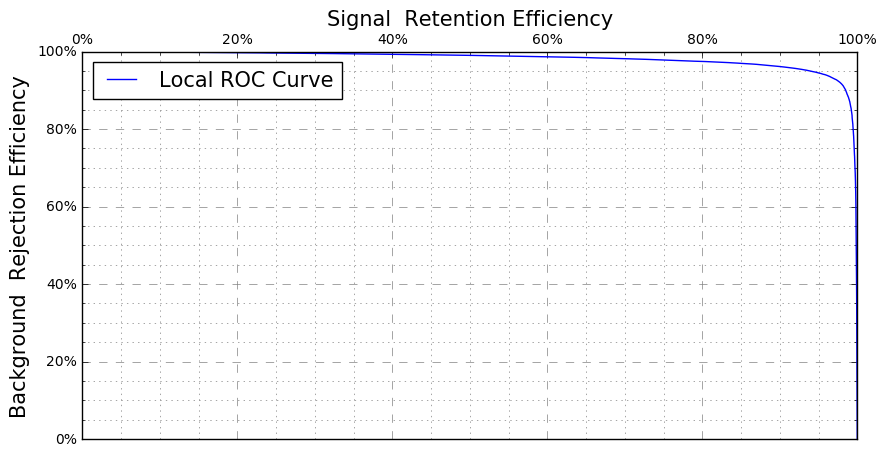

In [87]:
plot_roc_curve(train.cdc.get_measurement(train.cdc.hit_type_name, 
                                         events=evt_samp[1]+evt_samp[2],
                                         only_hits=True), 
               train.cdc.get_measurement(lcl_scr_name, 
                                         events=evt_samp[1]+evt_samp[2],
                                         only_hits=True), 
               zoom=False, label="Local ROC Curve")
print roc_auc_score(train.cdc.get_measurement(train.cdc.hit_type_name, 
                                         events=evt_samp[1]+evt_samp[2],
                                         only_hits=True), 
               train.cdc.get_measurement(lcl_scr_name, 
                                         events=evt_samp[1]+evt_samp[2],
                                         only_hits=True))
plt.show()

## Use Neighbour Level Features

In [88]:
# Define Data
neigh_train_features = [train.cdc.edep_name, 
                        train.cdc.edep_name + "_left",
                        train.cdc.edep_name + "_right",
                        rel_time_name, 
                        rel_time_name + "_left",
                        rel_time_name + "_right",
                        row_name]

In [89]:
# Define GBDT over neighbour-level features
neigh_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=neigh_train_features)
# Add the GBDT
factory.add_classifier('Neighbour and Local Features', neigh_gbdt)

In [90]:
# Train the classifier
factory.fit(DataFrame(
                np.vstack(
                    get_measurment_and_neighbours(train.cdc, train.cdc.edep_name, evt_samp[1]) +\
                    get_measurment_and_neighbours(train.cdc, train.cdc.time_name, evt_samp[1]) +\
                    [train.cdc.data[row_name][hit_masks[1]]]).T,
                columns=neigh_train_features), 
            train.cdc.data[train.cdc.hit_type_name][hit_masks[1]])
pass

model Local Features was trained in 51.65 seconds
model Neighbour and Local Features was trained in 93.16 seconds
Totally spent 144.81 seconds on training


In [91]:
# Print these predictions
train.cdc.data[ngh_scr_name] = neigh_gbdt.predict_proba(
    DataFrame(
        np.vstack(
            get_measurment_and_neighbours(train.cdc, train.cdc.edep_name) +\
            get_measurment_and_neighbours(train.cdc, train.cdc.time_name) +\
            [train.cdc.data[row_name]]).T,
        columns=neigh_train_features))[:,1]
# Invalidate the training sample
train.cdc.data[ngh_scr_name][np.logical_or(hit_masks[0], hit_masks[1])] = -1

0.988939388543


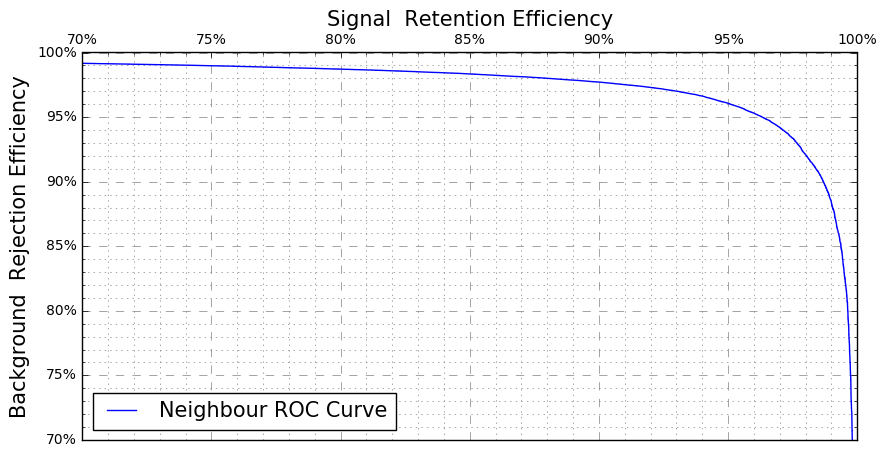

In [92]:
plot_roc_curve(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]], 
               train.cdc.data[ngh_scr_name][hit_masks[2]], 
               zoom=True, label="Neighbour ROC Curve")
print roc_auc_score(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]], 
               train.cdc.data[ngh_scr_name][hit_masks[2]])
plt.show()

In [93]:
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = abs(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]]
                        - train.cdc.data[ngh_scr_name][hit_masks[2]]) ** 2

In [94]:
print roc_auc_score(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]], 
                    train.cdc.data[ngh_scr_name][hit_masks[2]])
print roc_auc_score(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]], 
                    train.cdc.data[ngh_scr_name][hit_masks[2]],
                    sample_weight=problem_weights_2)

0.988939388543
0.218836009198


In [95]:
default = [[31.5, 34, 34.5, 2]]
submatrices = []

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(CDC(), sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                       sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [96]:
# Fit and transform the second data sample
hough_transformer = HoughTransformer(new_correspondence, \
                                     hough.norm_track_neighs,\
                                     train.cdc.get_measurement(ngh_scr_name,
                                                              events=evt_samp[2],
                                                              only_hits=False,
                                                              flatten=False),
                                     alpha_max=2., alpha_rw=2.)

In [97]:
# Get the hough results
#hough_score, hough_images = \
train.cdc.data[hgh_scr_name], hough_images = \
        hough_transformer.transform(train.cdc.get_measurement(ngh_scr_name, 
                                                             only_hits=False, 
                                                             flatten=False),
                                   only_hits=True, flatten=True)

In [98]:
# Add this to the feature list
track_train_features = neigh_train_features + [hgh_scr_name]

# Define the new classifier
hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=track_train_features) 

# Define GBDT over only energy deposit to compare
dep_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                               features=[train.cdc.edep_name])

# Ensure neigh-level GBDT has enough trees to compare properly
neigh_gbdt.set_params(n_estimators=200)
local_gbdt.set_params(n_estimators=200)

# Add the classifiers
factory.add_classifier('Track, Local and Neighbour Features', hough_gbdt)
factory.add_classifier('Energy Deposition', dep_gbdt)

In [99]:
# Train the classifier
factory.fit(DataFrame(
        np.vstack(
            get_measurment_and_neighbours(train.cdc, train.cdc.edep_name, events=evt_samp[2]) +\
            get_measurment_and_neighbours(train.cdc, train.cdc.time_name, events=evt_samp[2]) +\
            [train.cdc.get_measurement(row_name, only_hits=True,flatten=True, events=evt_samp[2])] +\
            [train.cdc.get_measurement(hgh_scr_name, only_hits=True,flatten=True, events=evt_samp[2])]).T,
        columns=track_train_features), 
    train.cdc.get_measurement(train.cdc.hit_type_name, only_hits=True,flatten=True, events=evt_samp[2]))
pass

model Local Features was trained in 102.19 seconds
model Neighbour and Local Features was trained in 190.46 seconds
model Track, Local and Neighbour Features was trained in 102.81 seconds
model Energy Deposition was trained in 71.80 seconds
Totally spent 467.26 seconds on training


## Save the Classifiers and Training Data

In [100]:
# Save the training sample and training data
import cPickle as pickle
from pandas import DataFrame

In [101]:
# Choose directory to save it to
classifiers_dir = "/vols/comet/users/elg112/ICEDUST/track-finding-yandex/classifiers/"
#train_name = "batch_3_4_2500"
#test_name = "batch_5_2675"
train_name = "batch_3_2500"
test_name = "batch_4_2536"

save_class = False
load_class = False
save_test = False
load_test = False

In [102]:
if save_class:
    # Save the classifier
    pickle.dump(factory, open(classifiers_dir + "class_"+train_name+".p", "wb" ) )
    # Save the transformer 
    pickle.dump(hough_transformer, open(classifiers_dir + "hough_"+train_name+".p", "wb" ))
    # Save the training sample and remove it
    pickle.dump(train.cdc, open(classifiers_dir + "train_"+train_name+".p", "wb" ) )

In [103]:
print "Memory Usage {}".format(memory_usage())
%xdel train
print "Memory Usage {}".format(memory_usage())

Memory Usage [1180.54296875]
Memory Usage [848.35546875]


In [104]:
if load_class:
    factory = pickle.load(open(classifiers_dir + "class_"+train_name+".p", "rb" ) )
    hough_transformer = pickle.load(open(classifiers_dir + "hough_"+train_name+".p", "rb" ) )
    local_gbdt = factory['Local Features']
    neigh_gbdt = factory['Neighbour and Local Features']
    hough_gbdt = factory['Track, Local and Neighbour Features']

In [105]:
print "Memory Usage {}".format(memory_usage())

Memory Usage [848.35546875]


## Test on the New Sample

In [107]:
%%memit
if load_test: 
    test_s = pickle.load(open(classifiers_dir + "test_"+test_name+".p", "rb" ) )
else:
    test_s = data_import_sample(sig_samples[1], back_samples[1], 
                              these_cuts=["500","Trig","Track"],
                              branches=these_branches,
                              empty_branches=empty_branches)
    set_additional_branches(test_s.cdc, 
                            row_name=row_name, 
                            cell_id=cell_id_name, 
                            relative_time=rel_time_name)

Using cuts
{ 'CDC': 'CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500 && 1 == 1 && 1 == 1',
  'CTH': 'CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500 && 1 == 1 && 1 == 1'}
Getting branches
{'CDC': ['CDCHit.fDriftTime', 'CDCHit.fTrack.fTrackID'], 'CTH': None}
Using cuts
{ 'CDC': 'CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500 && CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1',
  'CTH': 'CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500 && CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1'}
Getting branches
{'CDC': ['CDCHit.fDriftTime', 'CDCHit.fTrack.fTrackID'], 'CTH': None}
Trimming Signal Events
CTH Sig Events 2526 
CTH Back Events 2526 
CDC Sig Events 2526 
CDC Back Events 2526 
peak memory: 2014.99 MiB, increment: 785.53 MiB


In [108]:
if load_class:
    # Define features
    lcl_train_features = [test_s.cdc.edep_name, rel_time_name, row_name]
    neigh_train_features = [test_s.cdc.edep_name, 
                        test_s.cdc.edep_name + "_left",
                        test_s.cdc.edep_name + "_right",
                        rel_time_name, 
                        rel_time_name + "_left",
                        rel_time_name + "_right",
                        row_name]
    track_train_features = neigh_train_features + [hgh_scr_name]

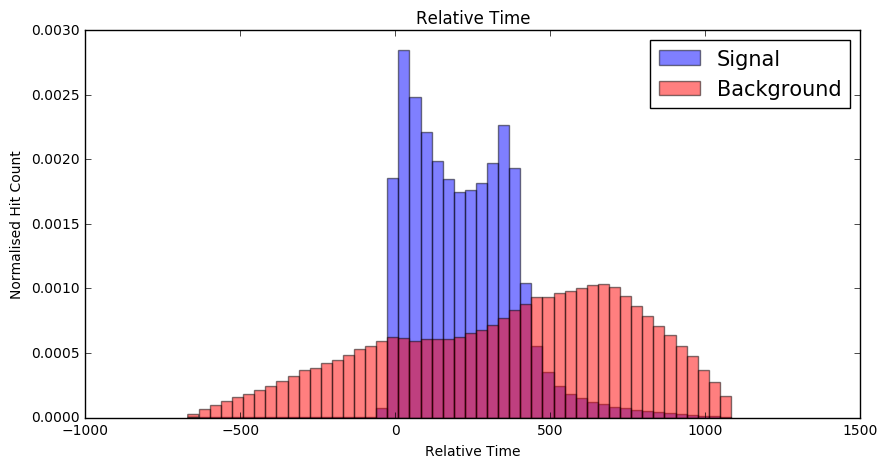

In [109]:
bins_for_plots = 50
plot_feature( test_s.cdc.get_signal_hits()[rel_time_name], 
              test_s.cdc.get_background_hits()[rel_time_name], 
              xlabel="Relative Time", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Relative Time", 
              nbins=bins_for_plots)
show()

In [110]:
if load_test:
    _ , hough_images = \
            hough_transformer.transform(test_s.cdc.get_measurement(ngh_scr_name, 
                                                                 only_hits=False, 
                                                                 flatten=False),
                                                    only_hits=True, flatten=True)
    default = [[31.5, 34, 34.5, 2]]
    submatrices = []

    # TODO test with several radii
    for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
        # Try with default values
        hough = HoughSpace(CDC(), sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                           sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
else: 
    # Get the local score predictions
    test_s.cdc.data[lcl_scr_name] = local_gbdt.predict_proba(DataFrame(test_s.cdc.data[lcl_train_features]))[:,1]
    # Remove coincident hits
    remove_coincidence(test_s.cdc)
    # Get the neighbouring score predictions
    test_s.cdc.data[ngh_scr_name] = neigh_gbdt.predict_proba(
        DataFrame(
            np.vstack(
                get_measurment_and_neighbours(test_s.cdc, test_s.cdc.edep_name) +\
                get_measurment_and_neighbours(test_s.cdc, test_s.cdc.time_name) +\
                [test_s.cdc.data[row_name]]).T,
            columns=neigh_train_features))[:,1]
    # Get the hough results
    test_s.cdc.data[hgh_scr_name], hough_images = \
            hough_transformer.transform(test_s.cdc.get_measurement(ngh_scr_name, 
                                                                 only_hits=False, 
                                                                 flatten=False),
                                       only_hits=True, flatten=True)
    # Test it on the last set of data
    test_s.cdc.data[trk_scr_name] = hough_gbdt.predict_proba(
            DataFrame(
                np.vstack(
                        get_measurment_and_neighbours(test_s.cdc, test_s.cdc.edep_name) +\
                        get_measurment_and_neighbours(test_s.cdc, test_s.cdc.time_name) +\
                        [test_s.cdc.data[row_name]] +\
                        [test_s.cdc.data[hgh_scr_name]]).T,
                columns=track_train_features)
            )[:,1]

In [111]:
if save_test:
    # Save the test_sample
    pickle.dump(test_s.cdc, open(classifiers_dir + "test_"+test_name+".p", "wb" ) )

In [112]:
final_diagnostics = factory.test_on(
    DataFrame(
        np.vstack(
            get_measurment_and_neighbours(test_s.cdc, test_s.cdc.edep_name) +\
            get_measurment_and_neighbours(test_s.cdc, test_s.cdc.time_name) +\
            [test_s.cdc.data[row_name]] +\
            [test_s.cdc.data[hgh_scr_name]]).T,
        columns=track_train_features), 
    test_s.cdc.data[test_s.cdc.hit_type_name])

# Visualize The Results

In [171]:
figsize(11, 7.3333)
%run visualizations.ipynb

Populating the interactive namespace from numpy and matplotlib


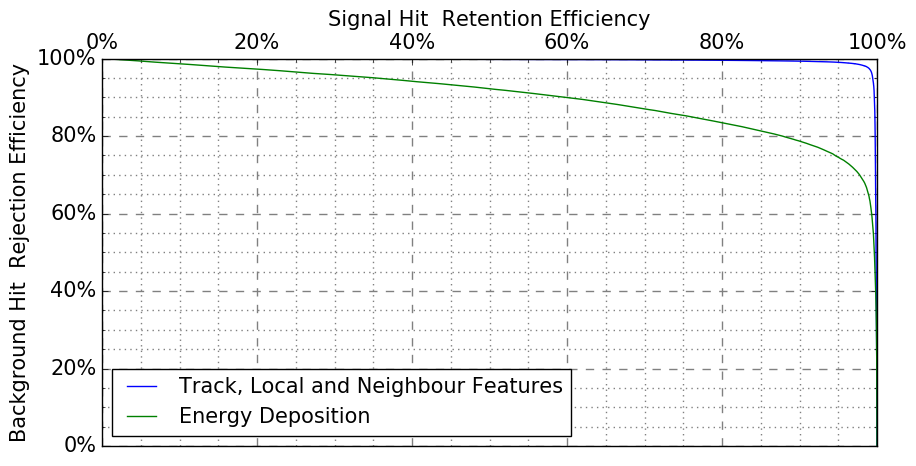

In [169]:
plot_set_font()
figsize(10, 5)
plot_rocs(test_s.cdc.get_measurement(test_s.cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
         final_diagnostics.prediction, 
         names=None,
         zoom=False,
         datum_label="Hit")
plt.show()

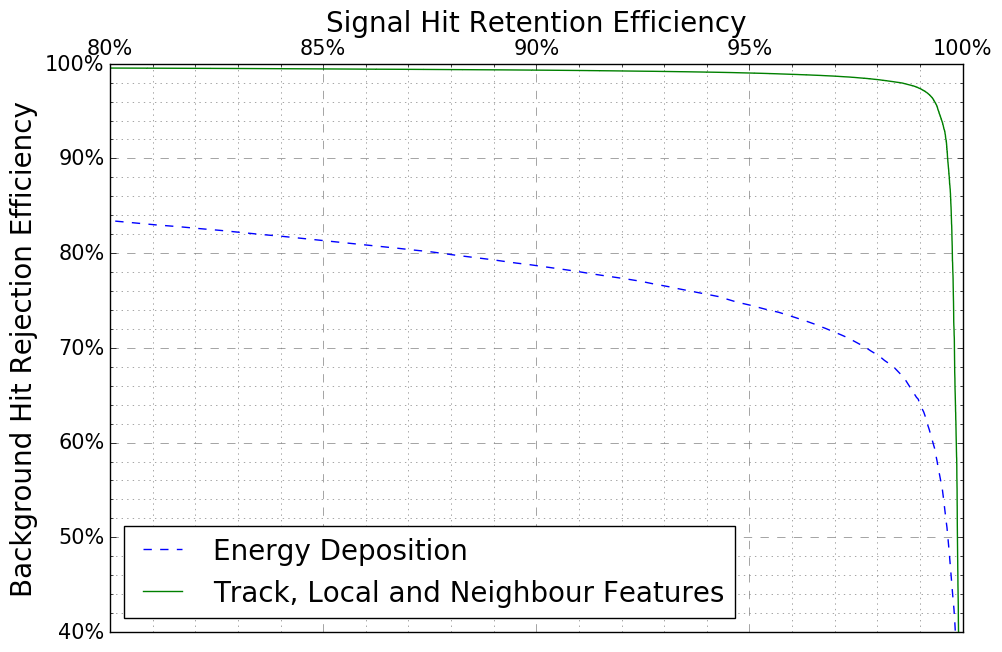

In [180]:
plot_set_font()
figsize(11, 7.3333)

plot_roc_curve(test_s.cdc.get_measurement(test_s.cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
               final_diagnostics.prediction["Energy Deposition"][:,1], 
         zoom=True,
         zoom_x_lims=[80,100],
         zoom_y_lims=[40,100],
         label="Energy Deposition",
         datum_label="Hit",
         ls="--",
         fontsize=20)
plot_roc_curve(test_s.cdc.get_measurement(test_s.cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
               final_diagnostics.prediction["Track, Local and Neighbour Features"][:,1], 
         zoom=True,
         zoom_x_lims=[80,100],
         zoom_y_lims=[40,100],
         label="Track, Local and Neighbour Features",
         datum_label="Hit",
         fontsize=20)
plt.show()

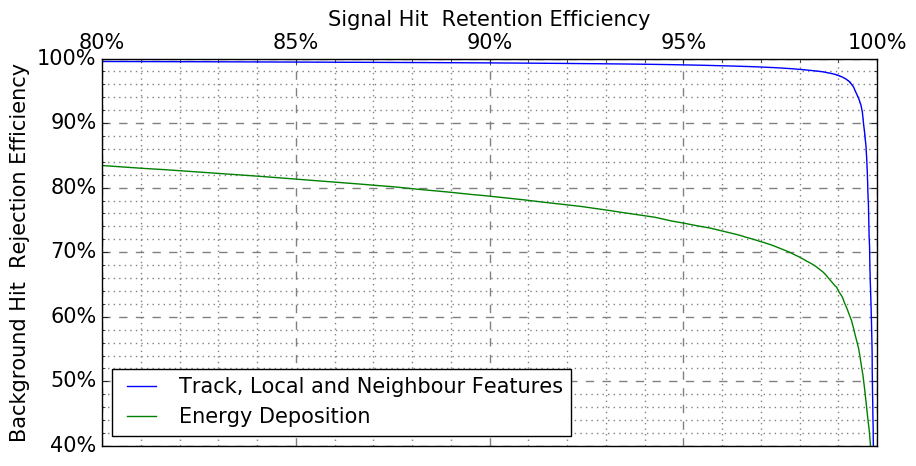

In [170]:
plot_set_font()
plot_rocs(test.cdc.get_measurement(test.cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
         final_diagnostics.prediction, 
         zoom=True,
         zoom_x_lims=[90,100],
         zoom_y_lims=[65,100],
         datum_label="Hit")
plt.show()

In [ ]:
figsize(10, 5)

In [ ]:
sig_occupy, back_occupy, occupy = test_s.cdc.get_occupancy()
plot_occupancies(sig_occupy, back_occupy, occupy, x_pos=0.4, y_pos=0.8)

In [ ]:
sig_occ, back_occ, occ = list(), list(), list()
for event in range(test_s.cdc.n_events):
    #sig_occ += [sum(test_s.cdc.get_signal_hits(event)[trk_scr_name])]
    #back_occ += [sum(test_s.cdc.get_background_hits(event)[trk_scr_name])]
    #occ += [sum(test_s.cdc.get_events(event)[trk_scr_name])]
    sig_hits = test_s.cdc.get_signal_hits(event)
    sig_hits = test_s.cdc.filter_hits("CDCHit.fTrack_Score", 
                                    these_hits=sig_hits,
                                    greater_than=0.624549)
    sig_occ += [len(np.unique(sig_hits[test_s.cdc.flat_name]))]
    bkg_hits = test_s.cdc.get_background_hits(event)
    bkg_hits = test_s.cdc.filter_hits("CDCHit.fTrack_Score", 
                                    these_hits=bkg_hits,
                                    greater_than=0.624549)
    back_occ += [len(np.unique(bkg_hits[test_s.cdc.flat_name]))]
    all_evt_hits = test_s.cdc.get_events(event)
    all_evt_hits = test_s.cdc.filter_hits("CDCHit.fTrack_Score", 
                                    these_hits=all_evt_hits,
                                    greater_than=0.624549)
    occ += [len(np.unique(all_evt_hits[test_s.cdc.flat_name]))]  

# print some infor
avg_n_hits = np.average(test_s.cdc.event_to_n_hits)
avg_occ = np.average(occ)
print "Sig Occ: {} , Back Occ : {}".format(np.average(sig_occ), np.average(back_occ))
print "All Occ: {}, {}".format(avg_occ, avg_occ/4482.)
print "NumHits: {}".format(avg_n_hits)
print "MinChansMultiHit: {}".format((avg_n_hits - avg_occ)/float(avg_occ))

In [ ]:
plot_set_font()
plot_occupancies(sig_occ, back_occ, occ, x_pos=0.4, y_pos=0.8)

In [ ]:
figsize(10, 5)

In [ ]:
labels = test_s.cdc.get_measurement(test_s.cdc.hit_type_name, 
                                  flatten=True)

In [ ]:
plot_feature( test_s.cdc.get_signal_hits()[test_s.cdc.time_name],
              test_s.cdc.get_background_hits()[test_s.cdc.time_name],
              xlabel="Detected time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Detected Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

In [ ]:
plot_feature( test_s.cdc.get_signal_hits()[test_s.cdc.time_name] -\
              test_s.cdc.get_signal_hits()[drift_name],  
              test_s.cdc.get_background_hits()[test_s.cdc.time_name] -\
              test_s.cdc.get_background_hits()[drift_name], 
              xlabel="Truth time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Truth Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

In [ ]:
plot_feature(  test_s.cdc.get_measurement(rel_time_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=-1000)[labels == 1], 
               test_s.cdc.get_measurement(rel_time_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=-1000)[labels == 0], 
              xlabel="Relative Timing", ylabel="Normalised Hit Count", 
              title="Relative timing of Left Hand Wire, No Hit = -1000",
              xlog=False, nbins=bins_for_plots)
show()

In [ ]:
plot_feature(  np.log10(test_s.cdc.get_measurement(test_s.cdc.edep_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=1)[labels == 1]), 
               np.log10(test_s.cdc.get_measurement(test_s.cdc.edep_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=1)[labels == 0]), 
              xlabel="log10(Number of Incident Electrons)", 
              ylabel="Normalised Hit Count", xlog=False,
              title="Charge deposited on the Left Wire, No Hit = 0", 
              nbins=bins_for_plots)
show()

In [ ]:
plot_feature( test_s.cdc.get_signal_hits()[lcl_scr_name], 
              test_s.cdc.get_background_hits()[lcl_scr_name],  
              xlabel="Local GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Local GBDT Output Distribution", nbins=bins_for_plots)
show()

In [ ]:
plot_feature( test_s.cdc.get_signal_hits()[ngh_scr_name], 
              test_s.cdc.get_background_hits()[ngh_scr_name], 
              xlabel="Neighbour-Level GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Neighbour-Level GBDT Output Distribution", nbins=bins_for_plots)
show()

In [ ]:
plot_feature( test_s.cdc.get_signal_hits()[hgh_scr_name], 
              test_s.cdc.get_background_hits()[hgh_scr_name], 
              xlabel="Inverse Hough Output", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Inverse Hough Transform Output Distribution", 
              nbins=bins_for_plots)
show()

In [ ]:
plot_feature( test_s.cdc.get_signal_hits()[trk_scr_name], 
              test_s.cdc.get_background_hits()[trk_scr_name],  
              xlabel="Track-Level GBDT Output", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Track-Level Output Distribution", 
              nbins=bins_for_plots)
show()

In [ ]:
from collections import OrderedDict
feat_label_dict = OrderedDict([
            (rel_time_name,               "Timing"),  
            (rel_time_name     +"_left",  "Left Timing"),  
            (rel_time_name     +"_right", "Right Timing"),  
            (test_s.cdc.edep_name,          "Charge"),  
            (test_s.cdc.edep_name+"_left",  "Left Charge"),  
            (test_s.cdc.edep_name+"_right", "Right Charge"),  
            (row_name,           "R Distance"),  
            (hgh_scr_name,               r"Hough, $W_j''$")
    ])

In [ ]:
figsize(6.4,6.4) 
plot_feature_importance(hough_gbdt, feat_label_dict)
show()
plot_feature_correlations(final_diagnostics, feat_label_dict)
show()

In [ ]:
plot_feature_importance(neigh_gbdt, feat_label_dict)
show()

## Visualiaze the Data

In [82]:
high_hit = np.arange(test_s.cdc.n_events)[test_s.cdc.event_to_n_hits >= 600]
#high_hit = np.where(test_s.cdc.event_to_n_hits >= 800)[0]
n_sig = np.array([len(test_s.cdc.get_signal_hits(evt)) for evt in high_hit])
good_event = high_hit[np.logical_and(n_sig > 70, n_sig < 80)]
print len(good_event)
print good_event

227
[   4    6    7   12   25   29   35   49   59   77   86  109  117  124  128
  146  166  182  185  190  195  197  203  204  209  211  214  231  280  286
  300  303  304  311  343  392  406  442  451  458  463  467  475  497  500
  509  511  525  527  538  552  554  562  581  595  605  606  619  620  647
  648  655  704  713  714  715  720  722  743  754  764  767  768  781  784
  805  806  811  842  869  878  879  897  902  917  921  929  972 1015 1044
 1052 1059 1076 1082 1099 1109 1129 1153 1172 1176 1179 1192 1204 1209 1213
 1217 1218 1223 1225 1239 1242 1243 1270 1271 1274 1303 1305 1307 1315 1322
 1328 1337 1344 1371 1375 1379 1397 1411 1416 1422 1425 1438 1446 1455 1492
 1503 1515 1543 1545 1548 1551 1558 1577 1578 1587 1596 1607 1614 1615 1625
 1632 1635 1636 1639 1641 1665 1686 1693 1702 1741 1786 1787 1788 1796 1806
 1809 1834 1842 1854 1856 1891 1910 1928 1938 1981 1988 1992 1995 2007 2012
 2026 2032 2034 2047 2067 2070 2089 2091 2113 2153 2168 2198 2213 2226 2231
 2235 22

In [130]:
# Event information\
event = 5
event = good_event[event]
#event = evt_samp[3][event]
add_trans = True
save = False
savedir = "/vols/comet/users/elg112/ICEDUST/track-finding-yandex/review_meeting_plots/"

to_plot = np.take([0,2,1], test_s.cdc.get_measurement("CDCHit.fIsSig", 
                                   events=event, 
                                   default=-1, 
                                   only_hits=False,
                                   flatten=True).astype(int) + 1)
ngh_pred_size = plot_norm_size(test_s.cdc.get_measurement(ngh_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True))
trk_pred_size = plot_norm_size(test_s.cdc.get_measurement(trk_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True))
hough_output = test_s.cdc.get_measurement(hgh_scr_name, 
                                        events=event, 
                                        default=0, 
                                        only_hits=False,
                                        flatten=True)

#hough_event = evt_samp[3][event]
hough_event = event

plot_hough_image_3 = hough_images[hough_event,:hough.track.n_points] +\
                     hough_images[hough_event,hough.track.n_points:] 
plot_hough_no_rw = hough_transformer.normed_corresp.T.dot(ngh_pred_size.T).T
plot_hough_no_rw = plot_hough_no_rw[:hough.track.n_points] + plot_hough_no_rw[hough.track.n_points:]

738.0


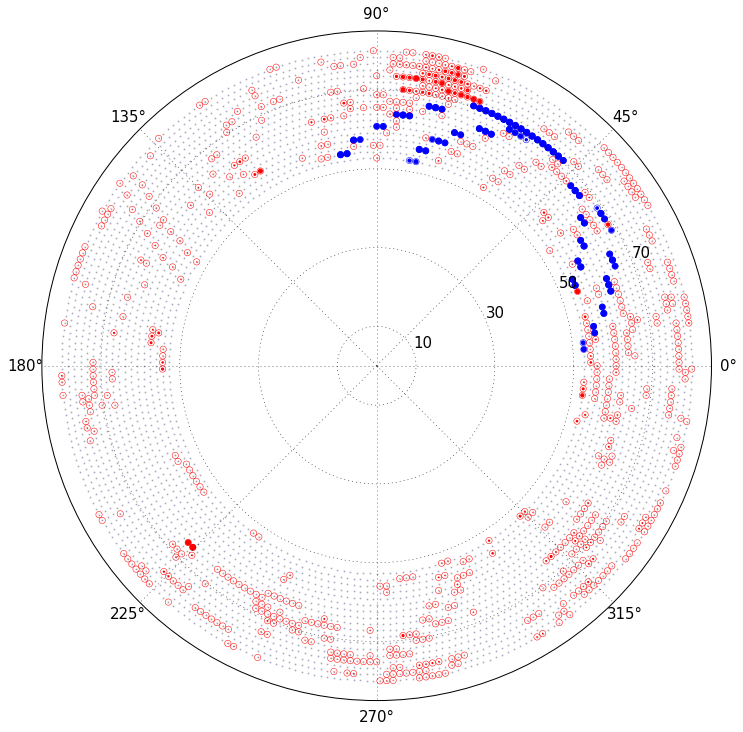

In [131]:
# First GBDT output
print occupy[event]
plot_output(to_plot, test_s.cdc.geom, 
            size=ngh_pred_size)
plot_add_outlines(to_plot, test_s.cdc.geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()

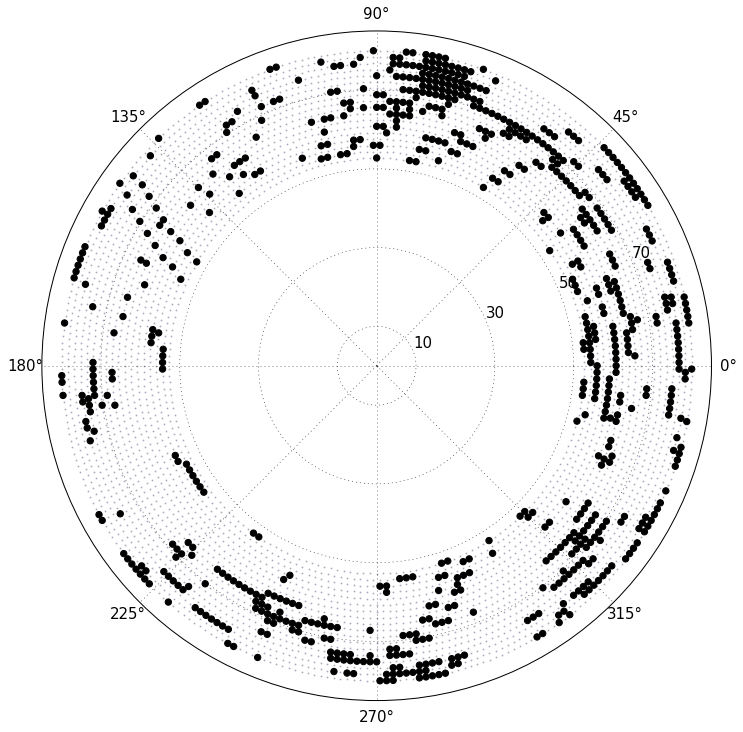

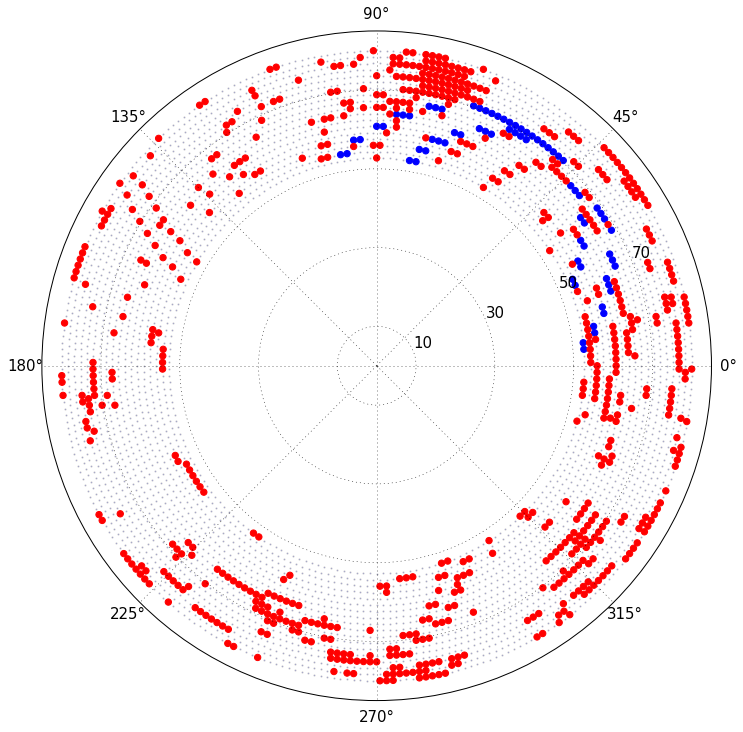

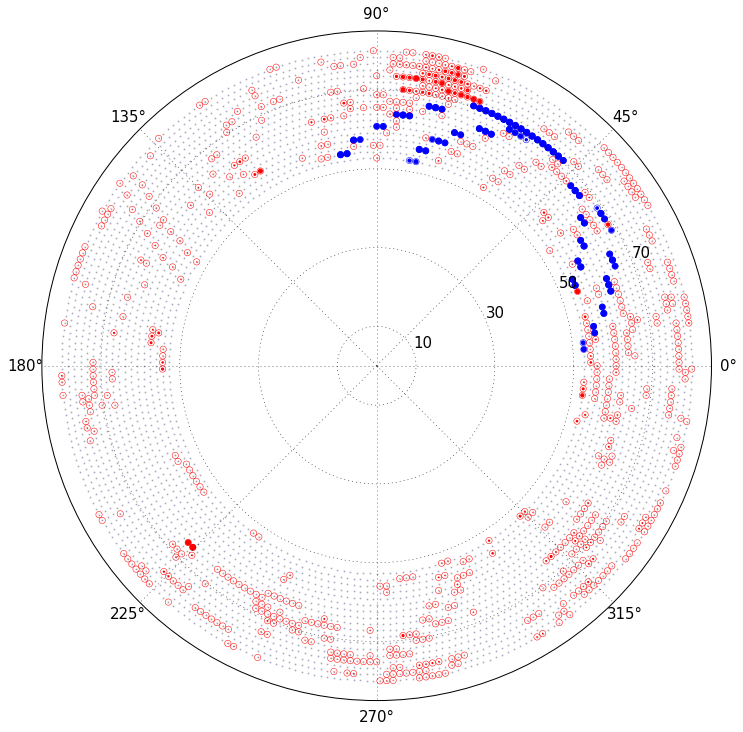

/home/elg112/development/miniconda2/envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Length of draw tracks are 2038


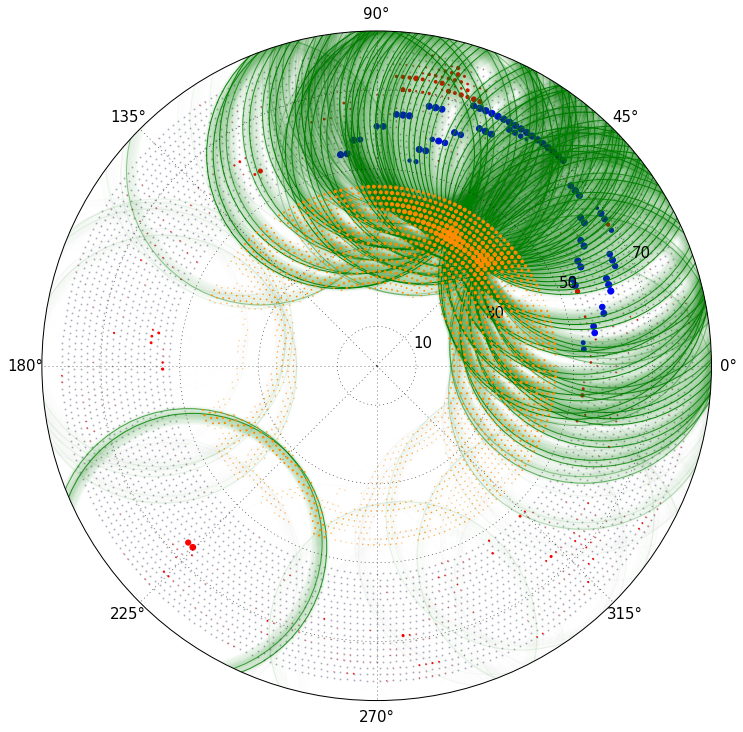

Length of draw tracks are 123


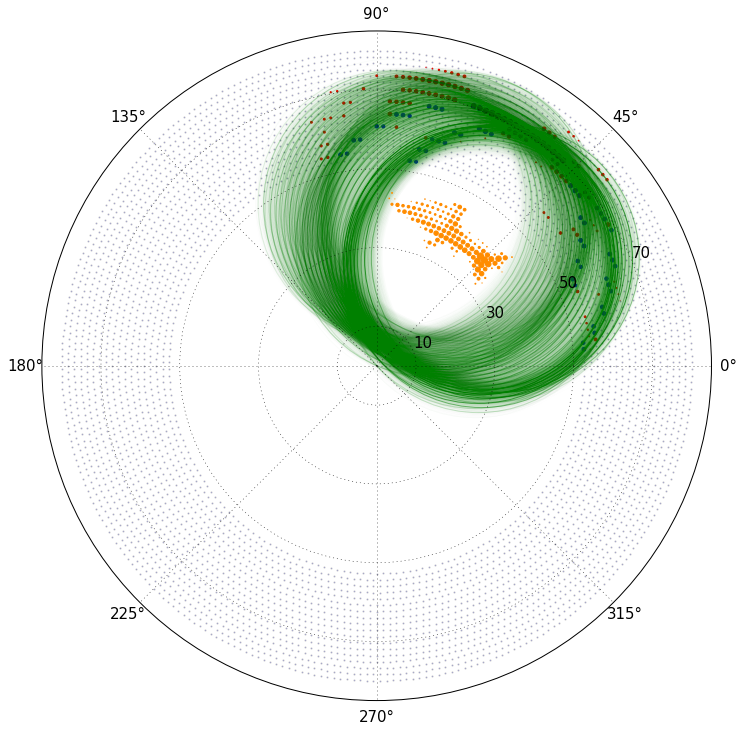

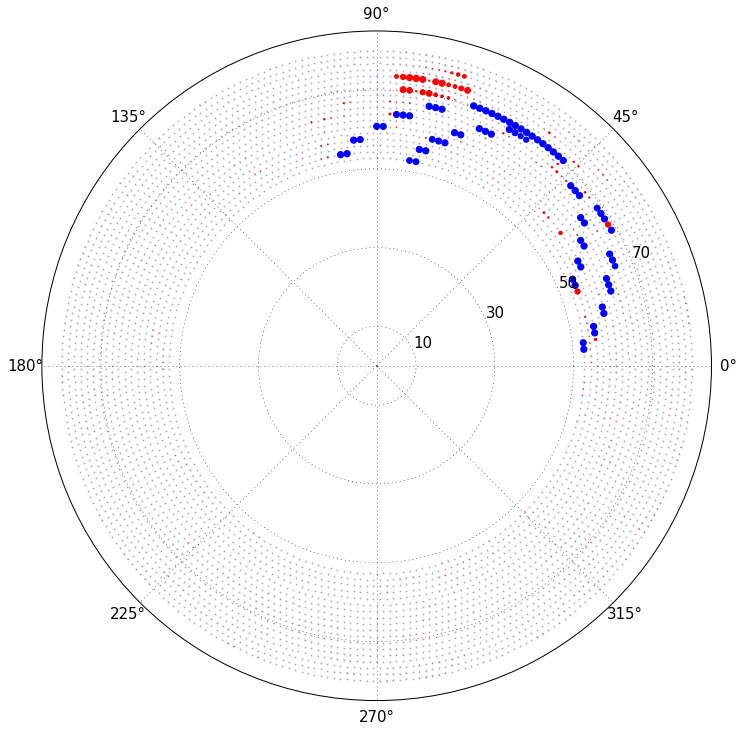

In [132]:
# Basic output
plot_output(to_plot, test_s.cdc.geom, sig_color='black', bkg_color='black', )
if save:
    plt.savefig(savedir+"plot_event_bw.png", bbox_inches='tight')
show()

plot_output(to_plot, test_s.cdc.geom)
if save:
    plt.savefig(savedir+"plot_event.png", bbox_inches='tight')
show()

# First GBDT output
plot_output(to_plot, test_s.cdc.geom, 
            size=ngh_pred_size)
plot_add_outlines(to_plot, test_s.cdc.geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()

# Hough output
plot_output(to_plot, test_s.cdc.geom, 
            size=ngh_pred_size, 
            add_transform=add_trans)
plot_add_tracks(test_s.cdc.geom, hough, 
                size=plot_norm_size(plot_hough_no_rw - np.amin(plot_hough_no_rw),40))
if save:
    plt.savefig(savedir+"plot_hough.png", bbox_inches='tight')
show()

# Inverse Hough output
plot_output(to_plot, test_s.cdc.geom, 
            size=plot_norm_size(hough_output))
plot_add_tracks(test_s.cdc.geom, hough, 
                size=plot_norm_size(plot_hough_image_3,40), 
                add_transform=add_trans,
                tolerance=0.00)
if save:
    plt.savefig(savedir+"plot_inv_hough.png", bbox_inches='tight')
show()    

# Final
plot_output(to_plot, test_s.cdc.geom, size=plot_norm_size(trk_pred_size))
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight')
show()

In [116]:
from tabulate import tabulate

In [117]:
def print_tpr_fpr(my_fpr, my_tpr, my_thresh, 
                  threshold_min=80, threshold_max=100, 
                  bins=100., steps=1,
                  filename=None):
    table = list()
    table.append([ "Bkg Retained", "Sig Retained", 'Threshold'])
    for this_thresh in np.arange(threshold_min,threshold_max, steps)[::-1]/float(bins):
        table.append([1. - this_thresh, my_tpr[my_fpr < 1. - this_thresh][-1], thresh[fpr < 1. - this_thresh][-1]])
    print tabulate(table, headers="firstrow")

In [118]:
fpr, tpr, thresh = roc_curve(test_s.cdc.data["CDCHit.fIsSig"], 
          test_s.cdc.data[trk_scr_name])

print_tpr_fpr(fpr, tpr, thresh, threshold_min=80, threshold_max=100, bins=100)
print_tpr_fpr(fpr, tpr, thresh, threshold_min=900, threshold_max=1000, bins=1000, steps=1)

  Bkg Retained    Sig Retained    Threshold
--------------  --------------  -----------
          0.01        0.952547   0.624549
          0.02        0.985075   0.154716
          0.03        0.991319   0.0505536
          0.04        0.993143   0.0234881
          0.05        0.993897   0.0121411
          0.06        0.994259   0.00707832
          0.07        0.994888   0.00495727
          0.08        0.99531    0.00383722
          0.09        0.995762   0.00320402
          0.1         0.996064   0.00274865
          0.11        0.99634    0.00242331
          0.12        0.996567   0.00219415
          0.13        0.996718   0.00199973
          0.14        0.996898   0.00182001
          0.15        0.997019   0.0016635
          0.16        0.99716    0.00153835
          0.17        0.997316   0.00143836
          0.18        0.997406   0.0013498
          0.19        0.997512   0.00127439
          0.2         0.997582   0.00119923
  Bkg Retained    Sig Retained    Thresho

In [ ]:
print_tpr_fpr(fpr, tpr, thresh, threshold_min=9000, threshold_max=10000, bins=10000, steps=1)

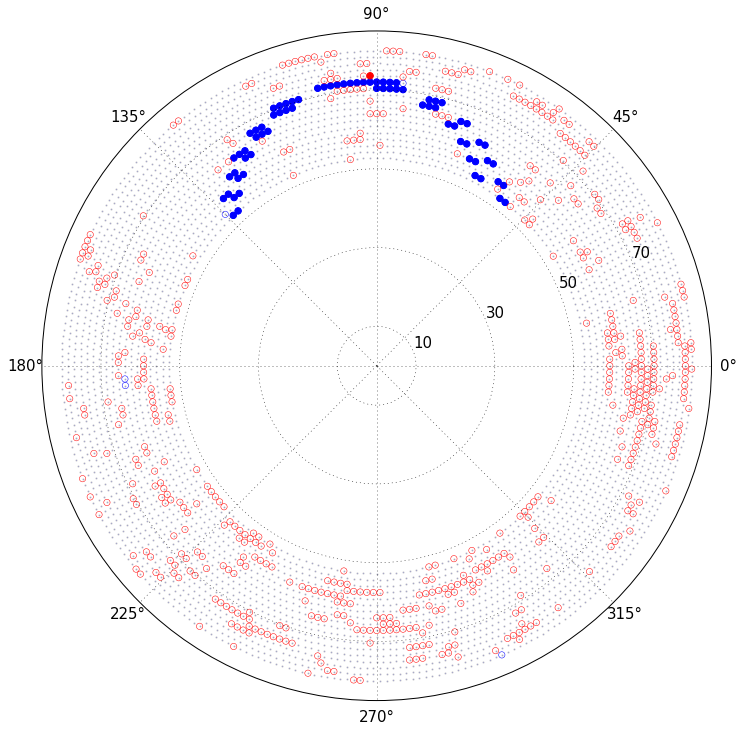

In [148]:
# Final
plot_output(to_plot, test_s.cdc.geom, size=plot_norm_size(test_s.cdc.get_measurement(trk_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True) > 0.49132))
plot_add_outlines(to_plot, test_s.cdc.geom)
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight')
show()

## Export the Data

In [ ]:
export_name = "track_finding_sample_scored_2.root"

In [ ]:
# Task 1 : Print signal only
# Task 2 : Print signal + background

In [ ]:
test_s.cdc.trim_hits(test_s.cdc.hits_index_name, 
                   values=test_s.cdc.data[hit_masks[3]][test_s.cdc.hits_index_name])

In [1]:
from rootpy.tree import Tree, TreeModel, FloatCol, IntCol
from rootpy.io import root_open
from rootpy.vector import LorentzVector
from rootpy import stl
from random import gauss, randint

# Map from python types to c++ types
type_dict_no_array = {dtype('float64'):"float", 
                      dtype('int32')  :"long",
                      dtype('int64')  :"long"}

type_dict_no_array = {dtype('float64'):"FloatCol()", 
                      dtype('int32')  :"IntCol()",
                      dtype('int64')  :"long"}

# Define the model of the output root file
class CDCTree(TreeModel):
    # Create a std::vector branch for each measurement
    for measure in test_s.cdc.data.dtype.names:
        this_dtype = type_dict[test_s.cdc.data.dtype[measure]]
        measure = measure.replace(".", "_")
        exec(measure + " = stl.vector(this_dtype)")
    # Delete branches we do not want
    del measure, this_dtype

# Open the output file
with root_open(savedir+export_name, mode='recreate') as output_file:
    # Open a new tree
    output_tree = Tree("test", model=CDCTree)
    for event in range(test_s.cdc.n_events):
        if event%100 == 0:
            print event
        event_hits = test_s.cdc.get_events(event)
        for measure in event_hits.dtype.names:
            this_measure = event_hits[measure]
            for hit_val in this_measure:
                output_tree[measure.replace(".","_")].push_back(hit_val)
        output_tree.fill(reset=True)
    output_tree.write()

INFO:rootpy.tree.chain] 2 files remaining
INFO:rootpy.tree.chain] current file: test_0.root
ERROR:ROOT.TFile.TFile] file test_0.root does not exist


ROOTError: level=3000, loc='TFile::TFile', msg='file test_0.root does not exist'

In [ ]:
fpr, tpr, thresh = roc_curve(test_s.cdc.data["CDCHit.fIsSig"], 
          test_s.cdc.data[trk_scr_name])

In [ ]:
def print_tpr_fpr(my_fpr, my_tpr, my_thresh, 
                  threshold_min=80, threshold_max=100, 
                  bins=100., steps=1,
                  filename=None):
    table = list()
    table.append([ "Bkg Retained", "Sig Retained", 'Threshold'])
    for this_thresh in np.arange(threshold_min,threshold_max, steps)[::-1]/float(bins):
        table.append([1. - this_thresh, my_tpr[my_fpr < 1. - this_thresh][-1], thresh[fpr < 1. - this_thresh][-1]])
    print tabulate(table, headers="firstrow")

In [ ]:
print_tpr_fpr(fpr, tpr, thresh, threshold_min=80, threshold_max=100, bins=100)
print_tpr_fpr(fpr, tpr, thresh, threshold_min=900, threshold_max=1000, bins=1000, steps=5)

In [ ]:
# TODO 
# Plots for Louis

# Penalize for not being the closest point to the fit



# Belle-II literature
# multiple radii
# optimize hough to improve track purity, use RANSAC to shed background islands
# 

#TODO Offline Analysis
# THURS penalize on no hits for RANSAC
# THURS change sampling probability via GBDT score
# THURS change scoring weight by GBDT score
# FRI check results for mulitple radii, no optimization
# FRI check results for varying hit efficiencies, no optimization


# In[73]:

#TODO Online
# TUES Integrate trigger signal in


# In[75]:

# NOTES
## Shifting to align image in hough space must 
#  play well with the placticity already 
#  implimented in the algorithm.  Adjust reweighting
## Try reweighting background hits close to signal hits
#  as worse when we do the track level GBDT algo.  Rid
#  background islands at RANSAC level.

In [ ]:
if load_test:
    _ , hough_images = \
            hough_transformer.transform(test_s.cdc.get_measurement(ngh_scr_name, 
                                                                 only_hits=False, 
                                                                 flatten=False),
                                                    only_hits=True, flatten=True)
    default = [[31.5, 34, 34.5, 2]]
    submatrices = []

    # TODO test with several radii
    for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
        # Try with default values
        hough = HoughSpace(CDC(), sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                           sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
else: 
    # Get the local score predictions
    test_s.cdc.data[lcl_scr_name] = local_gbdt.predict_proba(DataFrame(test_s.cdc.data[lcl_train_features]))[:,1]
    # Remove coincident hits
    remove_coincidence(test_s.cdc)
    # Get the neighbouring score predictions
    test_s.cdc.data[ngh_scr_name] = neigh_gbdt.predict_proba(
        DataFrame(
            np.vstack(
                get_measurment_and_neighbours(test_s.cdc, test_s.cdc.edep_name) +\
                get_measurment_and_neighbours(test_s.cdc, test_s.cdc.time_name) +\
                [test_s.cdc.get_measurement(row_name, only_hits=True,flatten=True)]).T,
            columns=neigh_train_features))[:,1]
    # Get the hough results
    test_s.cdc.data[hgh_scr_name], hough_images = \
            hough_transformer.transform(test_s.cdc.get_measurement(ngh_scr_name, 
                                                                 only_hits=False, 
                                                                 flatten=False),
                                       only_hits=True, flatten=True)
    # Test it on the last set of data
    test_s.cdc.data[trk_scr_name] = hough_gbdt.predict_proba(
        DataFrame(
            np.vstack(
                get_measurment_and_neighbours(test_s.cdc, test_s.cdc.edep_name) +\
                get_measurment_and_neighbours(test_s.cdc, test_s.cdc.time_name) +\
                [test_s.cdc.get_measurement(row_name, only_hits=True,flatten=True)] +\
                [test_s.cdc.get_measurement(hgh_scr_name, only_hits=True,flatten=True)]).T,
            columns=track_train_features)
        )[:,1]

In [ ]:
# Train the classifier
factory.fit(DataFrame(
                np.vstack(
                    get_measurment_and_neighbours(train.cdc, train.cdc.edep_name, evt_samp[1]) +\
                    get_measurment_and_neighbours(train.cdc, train.cdc.time_name, evt_samp[1]) +\
                    [train.cdc.get_measurement(row_name, evt_samp[1], only_hits=True,flatten=True)]).T,
                columns=neigh_train_features), 
            train.cdc.get_measurement(train.cdc.hit_type_name, evt_samp[1], only_hits=True,flatten=True))
pass

In [ ]:
# Print these predictions
train.cdc.data[ngh_scr_name] = neigh_gbdt.predict_proba(
    DataFrame(
        np.vstack(
            get_measurment_and_neighbours(train.cdc, train.cdc.edep_name) +\
            get_measurment_and_neighbours(train.cdc, train.cdc.time_name) +\
            [train.cdc.get_measurement(row_name, only_hits=True,flatten=True)]).T,
        columns=neigh_train_features))[:,1]
# Invalidate the training sample
train.cdc.data[ngh_scr_name][np.logical_or(hit_masks[0], hit_masks[1])] = -1

In [ ]:
plot_roc_curve(train.cdc.get_measurement(train.cdc.hit_type_name, 
                                         events=evt_samp[2],
                                         only_hits=True), 
               train.cdc.get_measurement(ngh_scr_name, 
                                         events=evt_samp[2],
                                         only_hits=True), 
               zoom=True, label="Neighbour ROC Curve")
print roc_auc_score(train.cdc.get_measurement(train.cdc.hit_type_name, 
                                         events=evt_samp[2],
                                         only_hits=True), 
               train.cdc.get_measurement(ngh_scr_name, 
                                         events=evt_samp[2],
                                         only_hits=True))
plt.show()